In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import seaborn
import glob

In [2]:
class CityLevelPostcodeFinder: 
    def __init__(self, data_directory) -> None:
        self.data_directory = data_directory
        self.postcodes = self._true_postcodes_finder() #i need bnrakets cuz i am calling a function
        self.cities_available = self._available_cities()

    def _available_cities(self):
        with open(f'{self.data_directory}available_cities.txt', 'r') as f:
            cities = f.read()
        return cities 

    def _true_postcodes_finder(self) -> pd.DataFrame: #its a method of the class!!!!!
        results = []
        for results_file in glob.glob(f'{self.data_directory}/*.pkl'):
            df = pd.read_pickle(results_file)
            results.append(df)
        all_results = pd.concat(results, axis=0, ignore_index=True)
        list_of_postcodes = all_results['website_postcodes'].to_list()
        postcodes = [item for item in list_of_postcodes if str(item) != 'nan']
        all_postcodes = [keys for dictionary in postcodes for keys, values in dictionary.items()]
        all_postcodes_df = pd.DataFrame(all_postcodes, columns = ['postcode'])
        uk_postcodes_centroids = pd.read_csv(f'{self.data_directory}/NSPL_NOV_2022_UK.csv')[['pcd', 'lat', 'long']]
        match_postcodes_centroids = all_postcodes_df.merge(uk_postcodes_centroids, right_on = 'pcd', left_on= 'postcode', how = 'right')
        true_postcodes = match_postcodes_centroids[match_postcodes_centroids['postcode'].notna()]
        true_postcodes = true_postcodes[~(true_postcodes['lat'] > 60)]
        return true_postcodes

    def city_level_processing(self, city: str) -> gpd.GeoDataFrame:   #you dont need data directory cause it is `self' 
        city_postcodes = pd.read_csv(f'{self.data_directory}/{city}/postcodes.csv')['Postcode']
        cc_city_postcodes = self.postcodes[self.postcodes['pcd'].isin(city_postcodes)]
        city_coordinates = cc_city_postcodes[['lat', 'long']]
        points = city_coordinates.apply(lambda r: Point(r.long, r.lat), axis=1)
        gdb = gpd.GeoDataFrame(city_coordinates.assign(geometry=points), \
                        crs={'init' :'epsg:4326'})
        xys = gdb['geometry'].apply(lambda pt: pd.Series({'x': pt.x, 'y': pt.y}))
        gdb['x'] = xys['x']
        gdb['y'] = xys['y']
        return gdb

In [3]:
cc_postcodes = CityLevelPostcodeFinder('/Users/gocchini/Desktop/CC_project/tutorial_following/')

/var/folders/0f/pzhfvnbj63jg3sk3nj099q3w0000gq/T/ipykernel_8805/1438166521.py:22: DtypeWarning: Columns (31,36) have mixed types. Specify dtype option on import or set low_memory=False.
  uk_postcodes_centroids = pd.read_csv(f'{self.data_directory}/NSPL_NOV_2022_UK.csv')[['pcd', 'lat', 'long']]


In [5]:
cc_postcodes._true_postcodes_finder()

/var/folders/0f/pzhfvnbj63jg3sk3nj099q3w0000gq/T/ipykernel_8805/1438166521.py:22: DtypeWarning: Columns (31,36) have mixed types. Specify dtype option on import or set low_memory=False.
  uk_postcodes_centroids = pd.read_csv(f'{self.data_directory}/NSPL_NOV_2022_UK.csv')[['pcd', 'lat', 'long']]


,postcode,pcd,lat,long
13227,AB243NA,AB243NA,57.160136,-2.105755
39182,AL1 1LJ,AL1 1LJ,51.749541,-0.334431
39200,AL1 1NG,AL1 1NG,51.750305,-0.337975
39212,AL1 1NX,AL1 1NX,51.749308,-0.334883
39223,AL1 1PL,AL1 1PL,51.747066,-0.330909
...,...,...,...,...
2682385,YO8 4QQ,YO8 4QQ,53.780824,-1.067113
2682674,YO8 6DQ,YO8 6DQ,53.813435,-0.918337
2682684,YO8 6EF,YO8 6EF,53.798217,-0.990657
2683150,YO8 8BE,YO8 8BE,53.781563,-1.061795


In [17]:
cc_postcodes.cities_available

'bristol'

In [80]:
bristol = cc_postcodes.city_level_processing('bristol')

/Users/gocchini/opt/anaconda3/envs/paper_3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [93]:
bristol_shp = gpd.read_file(f'{cc_postcodes.data_directory}bristol/bristol.shp')

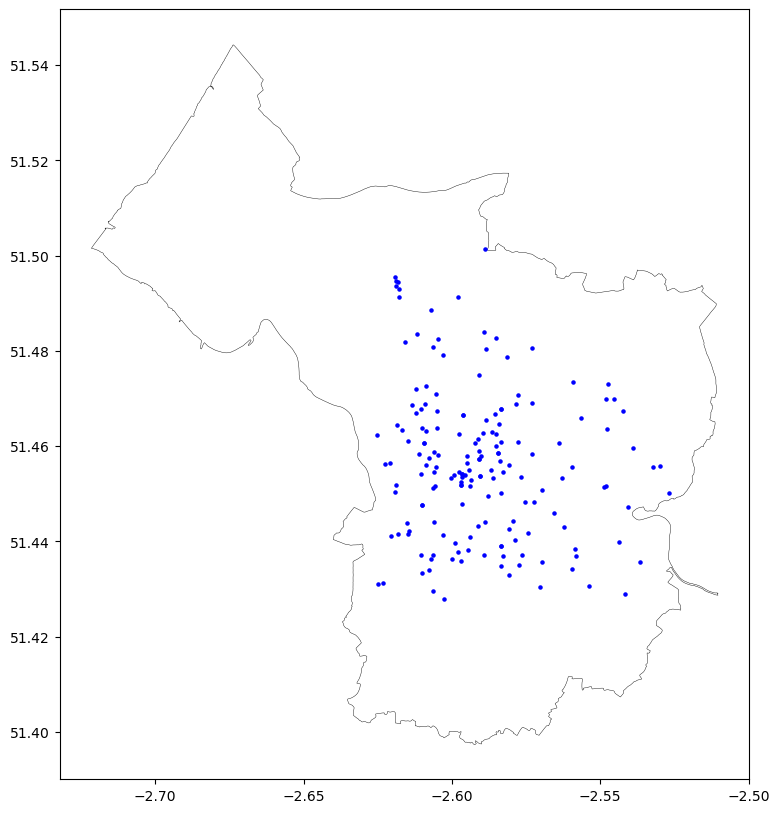

In [97]:
f, ax = plt.subplots(1, figsize=(10, 10))
# Add a base layer with the LSOA geography
bristol_shp.plot(ax = ax, color='white', edgecolor='black', linewidth=0.3)
#generate KDE
bristol.plot(ax=ax, color = 'blue', markersize = 5)
plt.show()